In [104]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# IBM Gestures

In [145]:
with h5py.File("../Results/attacks.h5", "r") as F:
    idx = F['attack_successful'][()]
    gt_all = F['ground_truth'][()]
    gt = gt_all[idx]
    sinabs_out = F['sinabs_label'][()]
    spk_orig = F['n_spikes_orig'][idx]
    spk_attk = F['n_spikes_attk'][idx]

In [146]:
print("Fraction of cases where sinabs got the right label:", (sinabs_out == gt_all).mean())
print("Fraction of successful attacks:", idx.mean())

Fraction of cases where sinabs got the right label: 0.833
Fraction of successful attacks: 0.777


In [147]:
report = np.loadtxt("../Results/report_0.3.csv", skiprows=1, delimiter=",")
_, gt2, chip_out, chip_out_attacked = report.T

assert np.all(gt == gt2)
assert len(gt) == len(spk_orig) == len(spk_attk)

In [148]:
print("Fraction of correct output on original:", (chip_out == gt).mean(), (chip_out==gt).sum())
successful_on_chip = chip_out != chip_out_attacked
print("Fraction of successful attacks among attacks that had converged:", successful_on_chip.mean(), successful_on_chip.sum())

Fraction of correct output on original: 0.9691119691119691 753
Fraction of successful attacks among attacks that had converged: 0.8532818532818532 663


In [149]:
spk_orig_succ = spk_orig[successful_on_chip]
spk_attk_succ = spk_attk[successful_on_chip]
L1 = spk_attk_succ - spk_orig_succ
incr = L1 / spk_orig_succ
print("Median L1:", np.median(L1))
print("Median increase:", np.median(incr))

Median L1: 903.0
Median increase: 0.0929294662776729


In [150]:
att_matrix = np.zeros((11, 11), dtype=int)
out_idx = chip_out[successful_on_chip].astype(int)
out_idx_att = chip_out_attacked[successful_on_chip].astype(int)
np.add.at(att_matrix, (out_idx, out_idx_att), 1)

In [151]:
class_labels = [
    "Hand Clap",
    "RH Wave",
    "LH Wave",
    "RH CW",
    "RH CCW",
    "LH CW",
    "LH CCW",
    "Arm Roll",
    "Air Drums",
    "Air Guitar",
    "Other",
]

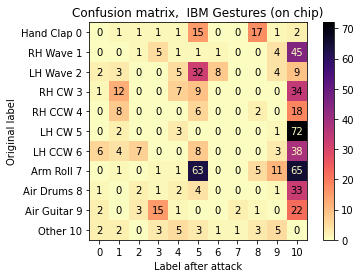

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(out_idx, out_idx_att)).plot(cmap=plt.cm.magma_r)
plt.xlabel("Label after attack")
plt.ylabel("Original label")
plt.yticks(range(11), [class_labels[i] + f" {i}" for i in range(11)])
plt.title("Confusion matrix,  IBM Gestures (on chip)")
plt.savefig("speck_attack_matrix.pdf", bbox_inches="tight")

In [98]:
dt = 2
bins = np.arange(0, 201, dt)

def get_histogram(spiketrain):
    times = spiketrain['t'] - spiketrain['t'][0]
    h, b = np.histogram(times / 1000, bins=bins)
    return h


F = h5py.File("../Results/attacks.h5", "r")

n = len(F['attacked_spiketrains'].keys())
h_or, h_att = np.zeros((2, n, 100))
print(n)
tot = 0
for i, k in enumerate(F['attacked_spiketrains'].keys()):
    h_or[i] = get_histogram(F['original_spiketrains'][k])
    tot += len(F['attacked_spiketrains'][k]) - len(F['original_spiketrains'][k])
    h_att[i] = get_histogram(F['attacked_spiketrains'][k]) - h_or[i]
    
F.close()

777


## Video

In [8]:
from aermanager.preprocess import create_raster_from_xytp

fps = 25
slowdown = 10
T = 0.2 # 200 ms
pause = 10
dt = 1000000/fps/slowdown
length = int(slowdown*fps*T)
bins = np.arange(129)

F = h5py.File("../Results/attacks.h5", "r")
N = 30
orig, attk = np.zeros((2, N*(length+pause), 128, 128))
orig_labels, attk_labels = [], []

attacked_IDs = sorted([int(k) for k in F['attacked_spiketrains'].keys()])

for i, k in enumerate(attacked_IDs):
#     if not successful_on_chip[i]: continue
    if i >= N: break

    spk_orig = F['original_spiketrains'][str(k)][()]
    spk_attk = F['attacked_spiketrains'][str(k)][()]
    orig_labels.append(chip_out[i])
    attk_labels.append(chip_out_attacked[i])
    
    start = i*(length+pause)

    raster_orig = create_raster_from_xytp(spk_orig, dt=dt, bins_x=bins, bins_y=bins)
    orig[start:start+length] = raster_orig[:, 1] - raster_orig[:, 0]
    raster_attk = create_raster_from_xytp(spk_attk, dt=dt, bins_x=bins, bins_y=bins)
    attk[start:start+length] = raster_attk[:, 1] - raster_attk[:, 0]

F.close()

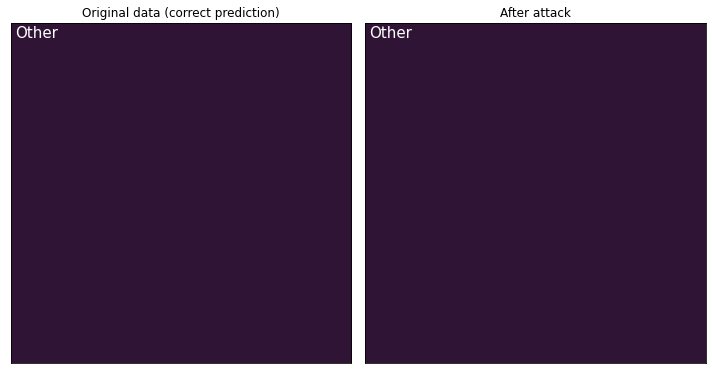

In [35]:
from matplotlib import animation

fig, ax = plt.subplots(1,2, figsize=(10, 5.5))

MAX = 3 

im = ax[0].imshow(
    np.zeros((128, 128)),
    interpolation='none',
    vmin=-MAX, vmax=MAX,
    cmap=plt.cm.twilight
)
ax[0].set_xticks([])
ax[0].set_yticks([])
im2 = ax[1].imshow(
    np.zeros((128, 128)),
    interpolation='none',
    vmin=-MAX, vmax=MAX,
    cmap=plt.cm.twilight
)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title("Original data (correct prediction)")
ax[1].set_title("After attack")

t = ax[0].text(1, 5, "Prediction:", c='white', size=15)
t2 = ax[1].text(1, 5, "Prediction:", c='white', size=15)

# initialization function: plot the background of each frame
def init():
    im.set_data(np.zeros((128, 128)))
    im2.set_data(np.zeros((128, 128)))
    
    return [im]

# animation function.  This is called sequentially
def animate(i):
    im.set_array(orig[i])
    im2.set_array(attk[i])
    
    orig_label = class_labels[int(orig_labels[i // (length + pause)])]
    attk_label = class_labels[int(attk_labels[i // (length + pause)])]
    t.set_text(orig_label)
    t2.set_text(attk_label)
    return [im]
      
fig.tight_layout()
anim = animation.FuncAnimation(fig, animate, init_func=init,
               frames=len(orig), blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=fps, dpi=150, extra_args=['-vcodec', 'libx264'])


plt.show()

# NMNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
nsamples = 1000
time_profile_orig = np.empty((nsamples, 60))
time_profile_attk_pos = np.empty((nsamples, 60))
time_profile_attk_neg = np.empty((nsamples, 60))
out_idx = np.empty(nsamples, dtype=int)
out_idx_attk = np.empty(nsamples, dtype=int)
successful = np.empty(nsamples, dtype=bool)
incr_nmnist = np.empty(nsamples)

for k in tqdm(range(nsamples)):
    
    with np.load(f"../Results/NMNIST_results/{k}.npz", allow_pickle=True) as f:
        x0 = f['arr_0'][()]['X0']
        time_profile_orig[k] = x0.sum((1,2,3)).cpu()
        
        diff = f['arr_0'][()]['X_adv'] - x0
        time_profile_attk_pos[k] = torch.clamp(diff, min=0).sum((1,2,3)).cpu()
        time_profile_attk_neg[k] = -torch.clamp(diff, max=0).sum((1,2,3)).cpu()
        
        out_idx[k] = f['arr_0'][()]['predicted']
        out_idx_attk[k] = f['arr_0'][()]['predicted_attacked']
        successful[k] = f['arr_0'][()]['success']
        
        l0 = f['arr_0'][()]['L0']
        assert time_profile_attk_pos[k].sum() + time_profile_attk_neg[k].sum() == l0
        incr_nmnist[k] = l0/ x0.sum()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
out_idx = out_idx[successful]
out_idx_attk = out_idx_attk[successful]
time_profile_orig = time_profile_orig[successful]
time_profile_attk_pos = time_profile_attk_pos[successful]
time_profile_attk_neg = time_profile_attk_neg[successful]
incr_nmnist = incr_nmnist[successful]

In [5]:
time_profile_attk_neg.sum(1).mean()

7.572144288577154

In [6]:
time_profile_attk_pos.sum(1).mean()

214.07615230460922

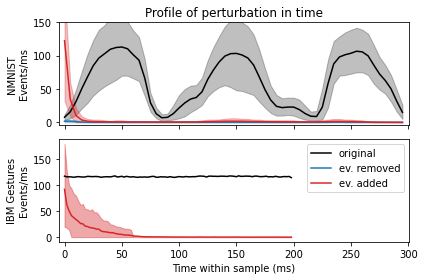

In [167]:
fig, ax = plt.subplots(2, 1, sharex=True)

# NMNIST
t = np.arange(0, 300, 5)
a, b = 10, 90

plt.sca(ax[0])
plt.plot(t, time_profile_orig.mean(0), c='k', label='original')
plt.fill_between(t, *np.percentile(time_profile_orig, (a, b), axis=0), color="k", alpha=0.25)

plt.plot(t, time_profile_attk_neg.mean(0), c="C0", label='ev. removed')
plt.fill_between(t, *np.percentile(time_profile_attk_neg, (a, b), axis=0), color="C0", alpha=0.3)

plt.plot(t, time_profile_attk_pos.mean(0), c="C3", label='ev. added')
plt.fill_between(t, *np.percentile(time_profile_attk_pos, (a, b), axis=0), color="C3", alpha=0.3)

plt.ylim([-4, 150])
plt.ylabel("NMNIST\nEvents/ms")
plt.title("Profile of perturbation in time")
# plt.xticks([])

# Gestures
plt.sca(ax[1])
plt.plot(bins[:-1], np.mean(h_or, axis=0), c='k', label='original')

plt.plot(bins[:-1], np.mean(h_att / dt, axis=0), c="C3", label='added')
qa, qb = np.percentile(h_att / dt, (a, b), axis=0)
plt.fill_between(bins[:-1], qa, qb, alpha=0.4, color="C3")

plt.ylabel("IBM Gestures\nEvents/ms")
plt.xlabel("Time within sample (ms)")
# plt.title("Profile of perturbation in time, IBM Gestures (chip)")
plt.legend(*ax[0].get_legend_handles_labels())
plt.xlim((-5, 301))

plt.tight_layout()
plt.savefig("added_in_time_both.pdf", bbox_inches='tight')

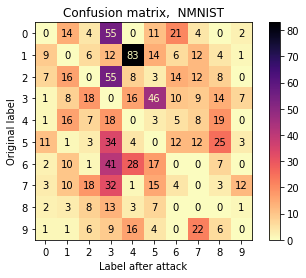

In [157]:
ConfusionMatrixDisplay(confusion_matrix(out_idx, out_idx_attk)).plot(cmap=plt.cm.magma_r)

plt.xlabel("Label after attack")
plt.ylabel("Original label")
plt.title("Confusion matrix,  NMNIST")
plt.savefig("nmnist_attack_matrix.pdf", bbox_inches="tight")

## Distribution of distances (both datasets)

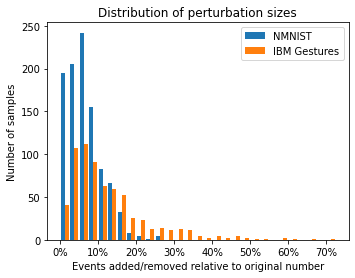

In [165]:
plt.figure(figsize=(5.4, 4))

distbins = np.arange(0, 0.75, 0.025)
plt.hist((incr_nmnist, incr), bins=distbins, label=("NMNIST", "IBM Gestures"));
plt.legend()

plt.xlabel("Events added/removed relative to original number")
plt.xticks(distbins[::4], [f"{b*100:.0f}%" for b in distbins[::4]])
plt.ylabel("Number of samples")
plt.title("Distribution of perturbation sizes")

plt.savefig("sparsefool_increases_dist_both.pdf")